In [1]:
import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
import os
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
from IPython.display import clear_output, display
import librosa
import math
import datetime
import time
import numpy as np

#Eigene Sachen
from train import train_model
from data.data import *
from util.util import *
from util.datasets import *
from util.audio_processing import *
import util.plot as plot
import models

c:\Program Files\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Program Files\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Program Files\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#%%timeit
#for i in np.random.randint(0, len(filedataset_train), size=1000):
#    waveform, sr, _ = filedataset_train[i]

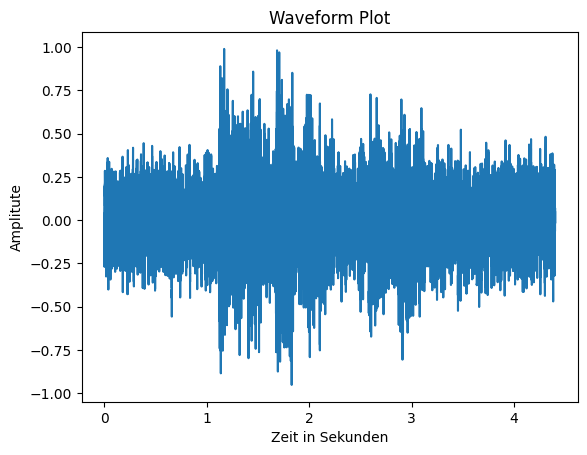

In [5]:
#PLOT
plot_idx = 1233
tensor, sr, _ = filedataset_train[plot_idx]
plot.plot_waveform(tensor, sr)

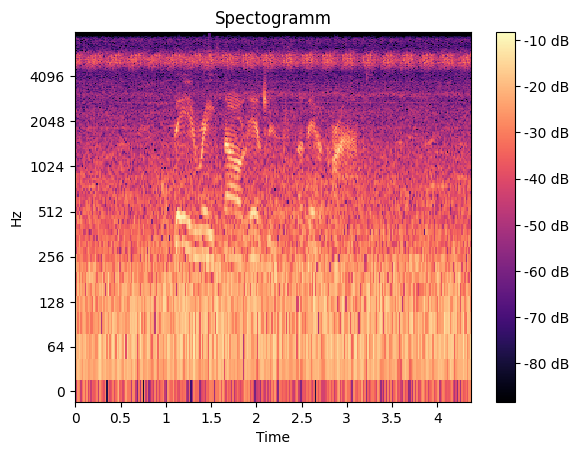

In [6]:
plot_idx = 1233
tensor, sr, _ = filedataset_train[plot_idx]
plot.plot_spectorgram(tensor, sr, SAMPLE_LENGTH, HOP_LENGTH)

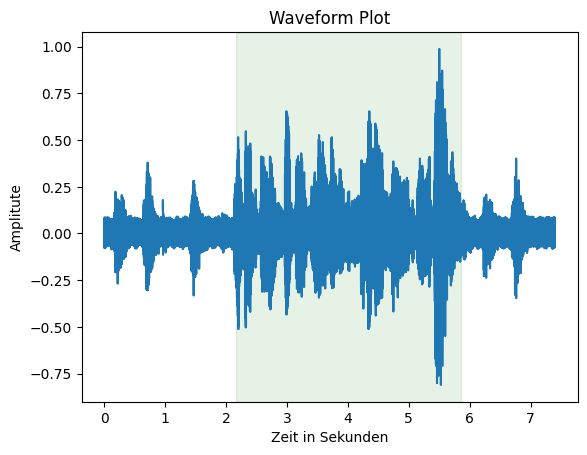

In [7]:
plot_idx = 53
tensor, sr, info = filedataset_train[plot_idx]
plot.plot_waveform_with_voice(tensor, get_y(tensor, sr, info), sr=sr)

Text(0.5, 1.0, 'Samples Plot')

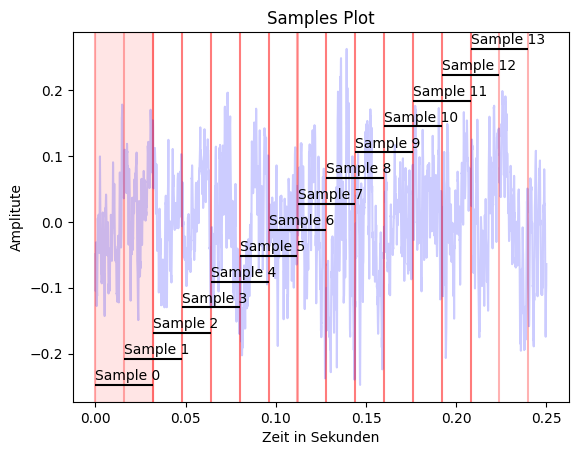

In [8]:
#BSP-Plot
plot_length = 0.25

plot_idx = 51
tensor, sr, _ = filedataset_train[plot_idx]

#x-Achse
time_axis = torch.arange(0,librosa.time_to_samples(plot_length,sr=SAMPLE_RATE)) / sr
time_axis.numpy()

#y-Achse
y = tensor[:time_axis.shape[-1]].numpy()

#Plottet Waveform
plt.plot(time_axis,y, color="blue", alpha=0.2)

#Plottet Samples
plot_data = get_samples(time_axis,SAMPLE_LENGTH, HOP_LENGTH)

y_max     = y.max()
y_min     = y.min()
n_samples = plot_data.shape[0]

for idx, sample in enumerate(plot_data):

    #Start und Ende
    start = sample[0]
    end   = sample[-1]
    
    #Plottet horizontale  Rote Linie
    plt.axvline(start, color="red", alpha=0.3, zorder = 1)
    plt.axvline(end,   color="red", alpha=0.3, zorder = 1)

    #Plottet schwarzen Strich mit Label Sample X
    sample_line_hight = y_min + abs(y_max - y_min) * idx / (n_samples - 1)
    plt.hlines(sample_line_hight, start, end, color="black")
    plt.annotate(f"Sample {idx}",(start, sample_line_hight), textcoords="offset pixels", xytext=(0,5))

    #plottet für ersen Idx noch den Hintergrund
    if idx == 0:
        plt.axvspan(xmin = start, xmax = end, alpha=0.1,color="red", label="Sample Länge")

plt.xlabel("Zeit in Sekunden")
plt.ylabel("Amplitute")
plt.title("Samples Plot")

None

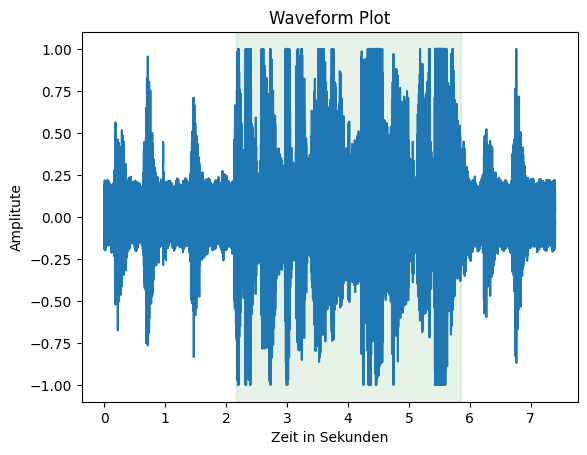

In [9]:
plot_idx = 53
tensor, sr, info = filedataset_train[plot_idx]

#Beispiel Hardclipper
hardclipper = RandomGain(6,12)
out_hardclipper = hardclipper(tensor)

#Out
display(Audio(out_hardclipper,rate=SAMPLE_RATE))
display(plot.plot_waveform_with_voice(out_hardclipper, get_y(tensor, sr, info), sr))

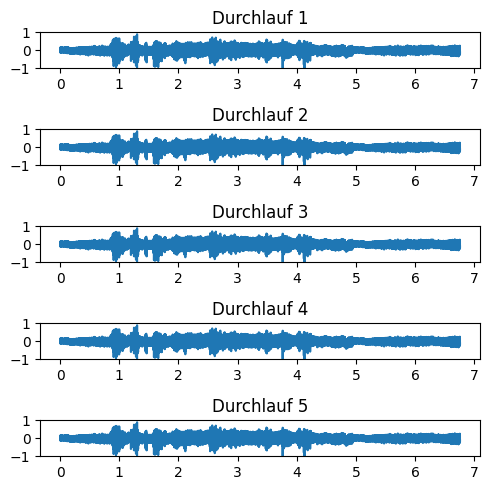

In [10]:
#Plot
_num_plots = 5
_plot_idx  = 0

fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):

    #Lädt Daten in unterschiedlichler Lautstärke
    x, y = speakdataset_train_unchunked[_plot_idx]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform(x, sr = SAMPLE_RATE, ax=ax, y_axis_0dbfs_scale=True)
    ax.set_title(f"Durchlauf {i + 1}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()

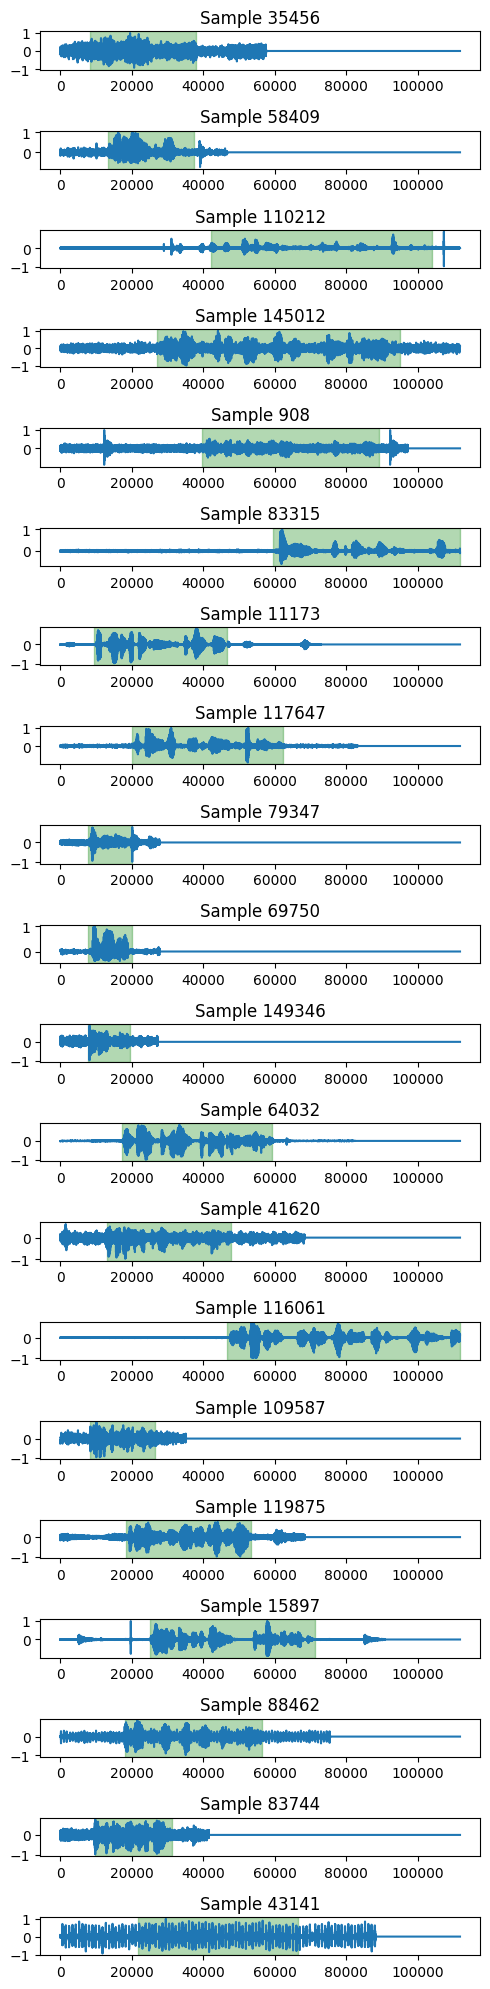

In [11]:
_num_plots = 20

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt random Sample
    random_idx = np.random.randint(0, len(dataset_train))
    x, y, = dataset_train[ random_idx ]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_model_result(x=x, y=y, sample_length = SAMPLE_LENGTH, hop_length=HOP_LENGTH, ax=ax)

    ax.set_title(f"Sample {random_idx}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()


Erstelle Plot: X : '0' Y : '0'
Erstelle Plot: X : '1' Y : '0'
Erstelle Plot: X : '2' Y : '0'
Erstelle Plot: X : '3' Y : '0'


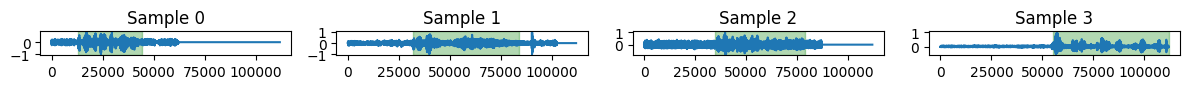

In [2]:
#Test
x, y = next(iter(dataloader_train))
plot.plot_batch(x, y, SAMPLE_LENGTH, HOP_LENGTH)

In [56]:
#Imports
import torchmetrics

#Accuracy
accuracy = torchmetrics.classification.BinaryAccuracy()

#Erstellt eigenes ChunkedDataset für Test
speak_test_dataset = ChunkedDataset(speak_test_dataset_unchunked, SAMPLE_LENGTH, SAMPLE_LENGTH, False)

#Ergebnis
pred_total = []
y_total    = []

#Iterriert über Sample
with torch.no_grad():
        
        #Iterriert Samples
        for x, y, idx in iter(speak_test_dataset):

                #Prediction
                pred = torch.zeros_like(y)

                #Iterriert Samples
                for pos, chunk in enumerate(x):
                        
                        start_pos = pos * chunk.size(-1)
                        end_pos   = start_pos + chunk.size(-1)
                        pred[start_pos : end_pos] = model(chunk).item()
                
                #Fügt Total an
                pred_total.append(pred)
                y_total.append(y)

#Tensor
y_total    = torch.hstack(y_total)
pred_total = torch.hstack(pred_total)

#Print für Accuracy
print("Accuracy auf Batch:", accuracy(pred_total, y_total))

Accuracy auf Batch: tensor(0.7535)


In [ ]:
#Lädt Sample
check_idx = 410

check_x = x[sample == check_idx]
check_y = y[sample == check_idx]
check_waveform    = reverse_unfold(check_x)


display(Audio(check_waveform,rate=SAMPLE_RATE))
display(plot_model_result(check_x,check_y,model(check_x)))

In [ ]:
from matplotlib.ticker import ScalarFormatter

#Plot
def plot_frequencyspectrum(waveform, window = SPEC_WINDOW):

    #X - Achse
    frequencies = torch.fft.rfftfreq(SAMPLE_LENGTH,d=1/16000)

    #Y-Achse
    spec = get_frequencyspectrum(waveform, window)

    #Plot
    fig, ax = plt.subplots()
    ax.plot(frequencies,spec)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    plt.title("Periodogram")
    plt.xlabel("Frequenz in Hz")
    plt.ylabel("Decibel")
    plt.ylim((-DECIBEL_LOW_TRESHOLD,0))
    plt.show()

In [ ]:
#Lädt Daten
x, _, _ = speak_train_dataset[76]
x = x[60]

plot_frequencyspectrum(x)

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        #STFT
        self.stft = STFT()
        
        #FeedForward
        self.fc1 = nn.Linear(len(torch.fft.rfftfreq(SAMPLE_LENGTH,d=1/16000)), 512)
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,1)
    
    def forward(self, x):


        #forward
        out = self.stft(x)
        
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.sigmoid(self.fc4(out))

        return out.view(out.shape[0])

In [ ]:
#erhöht Batch Size
dataloader_train = DataLoader(speak_train_dataset, batch_size=64, shuffle=True, collate_fn=costume_collate_fn, pin_memory=True, num_workers=0) 

In [ ]:
# KONSTANTEN
N_BATCHES = 200
N_BATCHES_PLOT = 20

#GPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

#CPU für debugging
device = torch.device("cpu")

#Instanz des Models
model     = Net().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.BCELoss()

#counters
epoch_counter = 0
batch_counter = 0

while True:

    loss_train = 0.0

    for sample, x, y in dataloader_train:
        
        #GPU
        x = x.to(device=device)
        y = y.to(device=device)

        #enable autograd
        x.requires_grad = True
        y.requires_grad = True

        #Forward
        output = model(x)

        #Loss
        loss = loss_fn(output, y)
 
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        #BATCH COUNTER
        batch_counter +=1
        
        #Print
        if batch_counter == 1 or batch_counter %N_BATCHES_PLOT == 0:
            print(f"{datetime.datetime.now()} Batch {batch_counter} Epoch {epoch_counter} Loss on Batch: {loss.item()}")

        #END
        if batch_counter >= N_BATCHES:
            break
    
    #Sucessfull Epoch
    else:
        epoch_counter += 1
        continue

    #END
    break

In [ ]:
#Exportiert Model
torch.save(model.state_dict(), "stftMLP.model")

In [ ]:
#lädt Model
model = Net()
model.load_state_dict(torch.load("stftMLP.model"))
model = model.eval()

In [ ]:
#Erstellt Datenloader für Test
dataloader_test  = DataLoader(speak_test_dataset,  batch_size=128,  shuffle=True, collate_fn=costume_collate_fn )


sample, x, y = next(iter(dataloader_test))
pred = model(x)

#Print für Accuracy
print("Accuracy auf Batch:", accuracy(pred,y))

#Plot
plot_batch(sample, x, y, model(x))

In [ ]:
#Plot
_tresh = -10

#Data
x,y,n = speak_train_dataset[100]


comp = Compressor(treshold=_tresh, ratio=2)
x_comp = comp(x)

waveform_original = reverse_unfold(x)
waveform_comp     = reverse_unfold(x_comp).detach()

plt.plot(waveform_original, color="blue", label="Original")
plt.plot(waveform_comp,     color="orange", label="Komprimiert")
plt.axhline(y= db_to_amp(_tresh), color="red")
plt.axhline(y= db_to_amp(_tresh) * -1, color="red")
plt.legend()
plt.title("Compressor")

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        #COMP
        self.compressor = Compressor(treshold= -10,  ratio=2, input_gain=6)
        self.limiter    = Compressor(treshold= -0.1, ratio=100)

        #STFT
        self.stft = STFT()
        
        #FeedForward
        self.fc1 = nn.Linear(len(torch.fft.rfftfreq(SAMPLE_LENGTH,d=1/16000)), 512)
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,1)
    
    def forward(self, x):


        #forward
        out = self.compressor(x)
        out = self.limiter(x)

        out = self.stft(x)
        
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.sigmoid(self.fc4(out))

        return out.view(out.shape[0])

In [ ]:
#erhöht Batch Size
dataloader_train = DataLoader(speak_train_dataset, batch_size=64, shuffle=True, collate_fn=costume_collate_fn, pin_memory=True, num_workers=0)